In [1]:
# To be run after Taiwan-Data-Prep-Marriage
# Import Data handling/display libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Union, Dict
# put this lower down.....
sns.set()
sns.set_context("talk")

# Import scikit-learn core slibraries
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import IBM's AI Fairness tooolbox
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing  # Preprocessing technique

# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set privileged / unprivileged / favourable / unfavourable values
protected_attr = 'MARRIAGE'
priv_grp       = 1
unpriv_grp     = 2
lab            = 'DEFAULT'
fav_label      = 0
unfav_label    = 1

In [3]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Marriage dataset
train = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv')
train.shape

(29623, 24)

In [4]:
train.sample(5)

,LIMIT_BAL,GENDER,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
22064,350000.0,2.0,1.0,2.0,32.0,0.0,0.0,0.0,0.0,2.0,...,295642.0,283684.0,282575.0,9501.0,10766.0,29060.0,55.0,10104.0,9324.0,0.0
17553,50000.0,1.0,1.0,2.0,23.0,0.0,0.0,0.0,0.0,0.0,...,8402.0,6646.0,7534.0,2000.0,2000.0,1500.0,500.0,1000.0,2000.0,0.0
21127,60000.0,2.0,3.0,1.0,49.0,0.0,0.0,0.0,0.0,0.0,...,49311.0,50290.0,51346.0,6751.0,6803.0,1821.0,1800.0,1866.0,1896.0,0.0
10638,70000.0,2.0,1.0,2.0,30.0,1.0,-2.0,-2.0,-2.0,-2.0,...,-50.0,-25.0,475.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0
8956,240000.0,2.0,3.0,2.0,50.0,0.0,0.0,0.0,0.0,0.0,...,191997.0,196221.0,200058.0,9490.0,8163.0,6753.0,7197.0,7176.0,5265.0,0.0


In [5]:
X = train.drop("DEFAULT",axis=1)
y = train["DEFAULT"]
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
print('number of rows in y_train', len(y_train))
print('number of rows in y_test', len(y_test))
print('These are counts and values for y_train')
print(y_train.value_counts())
print('These are counts and values for y_test')
print(y_test.value_counts())

number of rows in y_train 23698
number of rows in y_test 5925
These are counts and values for y_train
0.0    18505
1.0     5193
Name: DEFAULT, dtype: int64
These are counts and values for y_test
0.0    4571
1.0    1354
Name: DEFAULT, dtype: int64


In [6]:
# Scale the Test and Train dataframes 
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(copy=False)
#X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
#X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [7]:
#print ("Counts of males (1s) and females (0s)")
#print (train.GENDER.value_counts())

In [8]:
## print ("Counts of singles (2s) and Marrieds (1s)")
print (train.MARRIAGE.value_counts())

2.0    15964
1.0    13659
Name: MARRIAGE, dtype: int64


In [9]:
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")
#print(classification_report(y_test, logpredictions))
#confusion_matrix(y_test, logpredictions)

Logistic regression validation accuracy: 0.7714767932489451


In [10]:
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=4)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")
#print(classification_report(y_test, rfcpredictions))
#confusion_matrix(y_test, rfcpredictions)

Random forest validation accuracy: 0.8118143459915612


In [11]:
# Create a Binary Label Dataset to use with AIF360 APIs
# Favourable Label : DEFAULT = 1 (no default)
# Favourable Label : DEFAULT = 0 (Default)
train_pp_bld = BinaryLabelDataset(df=pd.concat((X_train, y_train), axis=1),
                                  label_names=[lab], protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)
privileged_groups   = [{protected_attr: priv_grp}]   # Married folk (male or female)
unprivileged_groups = [{protected_attr: unpriv_grp}] # Single folk  (male or female)

In [12]:
# Create and explain a metric object from the BIASED Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print("# of instances                :", metric_train_bld.num_instances())
print("Base Rate                     :", metric_train_bld.base_rate())
print("Consistency                   :", metric_train_bld.consistency())
print("Disparate Impact              :", metric_train_bld.disparate_impact())
print("Mean Difference               :", metric_train_bld.mean_difference())
print("# of negatives(privileged)    :", metric_train_bld.num_negatives(privileged=True))
print("# of negatives(non-privileged):", metric_train_bld.num_negatives(privileged=False))
print("# of positives(privileged)    :", metric_train_bld.num_positives(privileged=True))
print("# of positives(non-privileged):", metric_train_bld.num_positives(privileged=False))
print("Statistical Parity Diference  :", metric_train_bld.statistical_parity_difference()) 

# of instances                : 23698.0
Base Rate                     : 0.7808675837623428
Consistency                   : [0.7525192]
Disparate Impact              : 1.0325233719294622
Mean Difference               : 0.024958619151072337
# of negatives(privileged)    : 2539.0
# of negatives(non-privileged): 2654.0
# of positives(privileged)    : 8377.0
# of positives(non-privileged): 10128.0
Statistical Parity Diference  : 0.024958619151072337


In [13]:
# Now attempt to mitigate the bias using pre-processing Reweighing, apply to Training dataset
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
# trained model with new weights..
train_pp_bld_f = rw.fit_transform(train_pp_bld)

In [14]:
# Create Dataframe from Training dataset and new weights and display weights 
pd.DataFrame({'MARRIAGE': X_train.MARRIAGE,
              'DEFAULT': y_train,
              'Original_weight': np.ones(shape=(X_train.shape[0],)),
              'new_weight': train_pp_bld_f.instance_weights}).sample(5)

,MARRIAGE,DEFAULT,Original_weight,new_weight
4570,2.0,0.0,1.0,0.985491
16052,2.0,0.0,1.0,0.985491
4211,1.0,0.0,1.0,1.017542
24091,2.0,1.0,1.0,1.055369
13075,2.0,0.0,1.0,0.985491


In [15]:
# Create and explain a metric object from the DE-BIASED Binary Label Dataset.
metric_train_bld = BinaryLabelDatasetMetric(train_pp_bld_f,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
print("# of instances                :", metric_train_bld.num_instances())
print("Base Rate                     :", metric_train_bld.base_rate())
print("Consistency                   :", metric_train_bld.consistency())
print("Disparate Impact              :", metric_train_bld.disparate_impact())
print("Mean Difference               :", metric_train_bld.mean_difference())
print("# of negatives(privileged)    :", metric_train_bld.num_negatives(privileged=True))
print("# of negatives(non-privileged):", metric_train_bld.num_negatives(privileged=False))
print("# of positives(privileged)    :", metric_train_bld.num_positives(privileged=True))
print("# of positives(non-privileged):", metric_train_bld.num_positives(privileged=False))
print("Statistical Parity Diference  :", metric_train_bld.statistical_parity_difference()) 

# of instances                : 23698.0
Base Rate                     : 0.7808675837623428
Consistency                   : [0.7525192]
Disparate Impact              : 1.0
Mean Difference               : 0.0
# of negatives(privileged)    : 2392.0494556502663
# of negatives(non-privileged): 2800.9505443497346
# of positives(privileged)    : 8523.950544349735
# of positives(non-privileged): 9981.049455650267
Statistical Parity Diference  : 0.0


In [16]:
# Use the new Dataframe 
unbiasedlogmodel = LogisticRegression()
unbiasedlogmodel.fit(X_train, y_train, sample_weight=train_pp_bld_f.instance_weights)
print(f"Biased   Logistic regression validation accuracy: {biasedlogmodel.score(X_test,y_test)}")
print(f"Unbiased Logistic regression validation accuracy: {unbiasedlogmodel.score(X_test, y_test)}")

Biased   Logistic regression validation accuracy: 0.7714767932489451
Unbiased Logistic regression validation accuracy: 0.7714767932489451


In [17]:
unbiasedrfcmodel = RandomForestClassifier(n_estimators=100, max_depth=4)
unbiasedrfcmodel.fit(X_train, y_train, sample_weight=train_pp_bld_f.instance_weights)
print(f"Biased   Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")
print(f"Unbiased Random forest validation accuracy: {unbiasedrfcmodel.score(X_test, y_test)}")

Biased   Random forest validation accuracy: 0.8118143459915612
Unbiased Random forest validation accuracy: 0.8124894514767933


Accuracy:


,LogReg,RFC
Unfair,0.771477,0.811814
Fair,0.771477,0.812489


AUC:


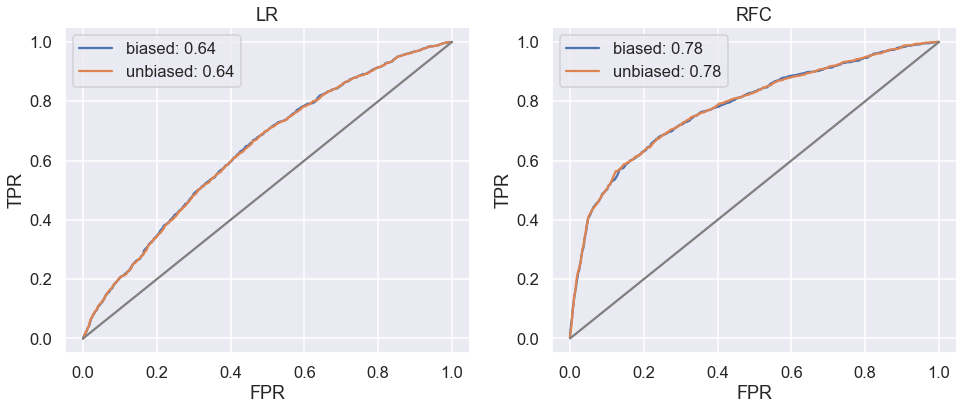

In [18]:
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray],
             title: str='', 
             ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, 
                          y=tpr,
                          ci=None,
                          ax=ax
                         )
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1],
                 y=[0, 1],
                 color='gray',
                 ax=ax)
    
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [biasedlogmodel.score(X_test, y_test), 
                                 unbiasedlogmodel.score(X_test, y_test)],
                      'RFC': [biasedrfcmodel.score(X_test, y_test),
                              unbiasedrfcmodel.score(X_test, y_test)]}, 
                     index =['Unfair', 'Fair']))

print('AUC:')
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
plot_auc(y_test, 
         {'biased': biasedlogmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedlogmodel.predict_proba(X_test)[:, 1]},
         title='LR',
         ax=ax[0]) 
plot_auc(y_test, 
         {'biased': biasedrfcmodel.predict_proba(X_test)[:, 1],
          'unbiased': unbiasedrfcmodel.predict_proba(X_test)[:, 1]},
         title='RFC',
         ax=ax[1]) 
plt.show()

In [19]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

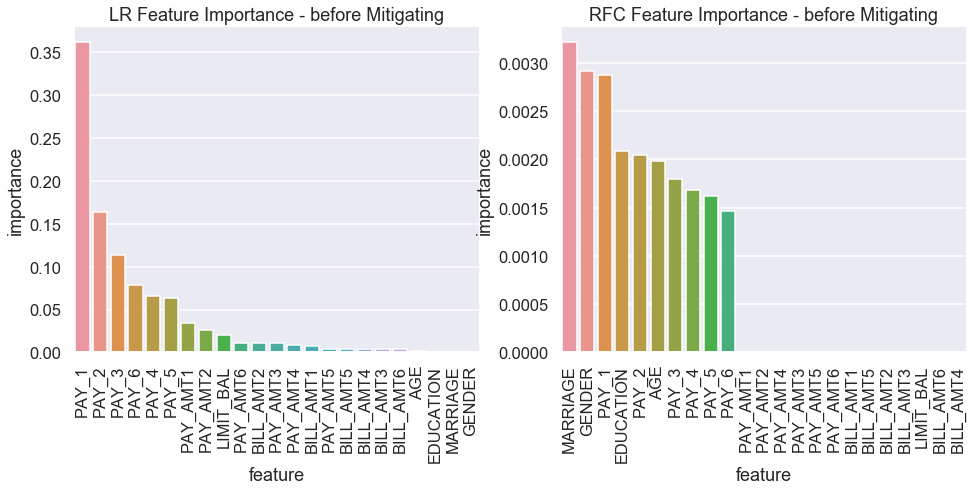

In [20]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(biasedrfcmodel,
                                                names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')

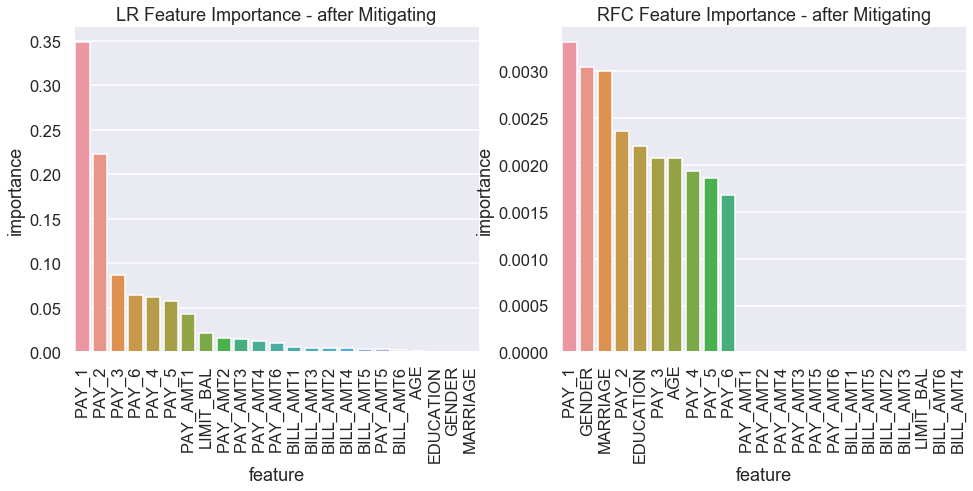

In [21]:
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - after Mitigating')
plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(unbiasedrfcmodel,
                                                names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - after Mitigating')

In [22]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true),
                                               axis=1),
                                  label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label,
                                  unfavorable_label=unfav_label)

    privileged_groups = [{protected_attr: priv_grp}]
    unprivileged_groups = [{protected_attr: unpriv_grp}]
    
    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy = []
    balanced_accuracy = []
    disp_impact = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

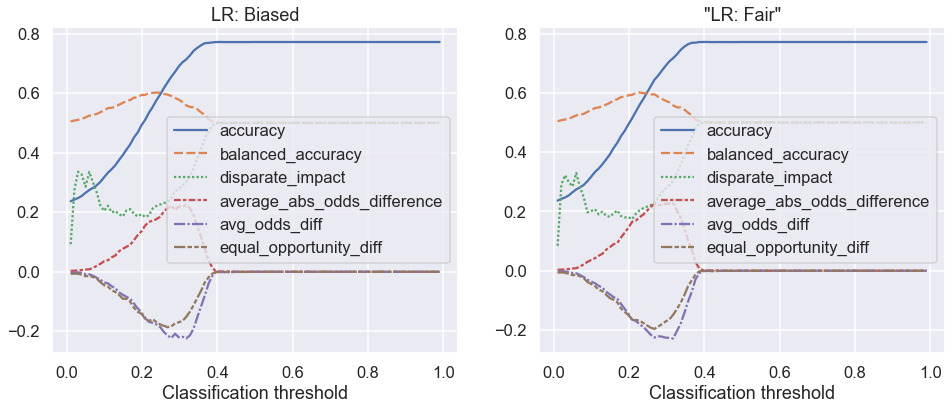

In [23]:
# Plot for LR
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biasedlogmodel, X_test, y_test),
                ax=ax[0],
                title="LR: Biased")
    
    plot_metrics(calc_metrics(unbiasedlogmodel, X_test, y_test),
                ax=ax[1],
                title='"LR: Fair"')

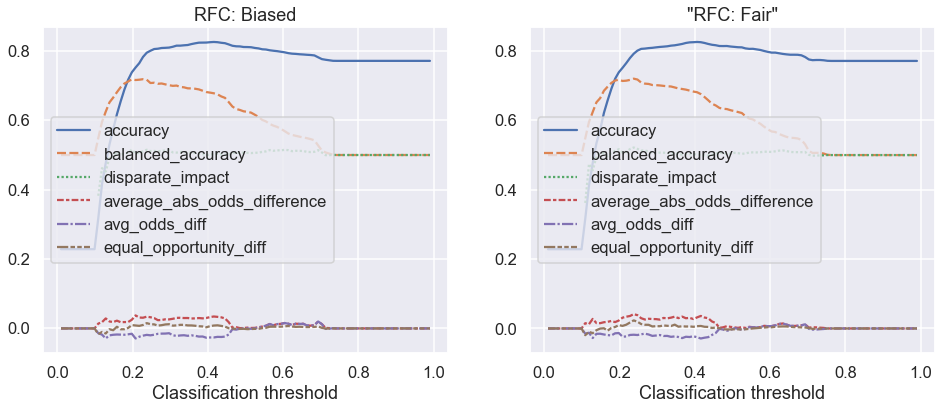

In [24]:
# Plot for RFC
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(biasedrfcmodel, X_test, y_test),
                ax=ax[0],
                title="RFC: Biased")
    
    plot_metrics(calc_metrics(unbiasedrfcmodel, X_test, y_test),
                ax=ax[1],
                title='"RFC: Fair"')